# Point-to-Mesh Similarity Analysis

This notebook demonstrates how to:
1. Load two meshes
2. Specify a particular point on the source mesh
3. Color-map the target mesh based on similarity to that point

The analysis uses diffusion features + DINO features to compute semantic similarity between mesh vertices.

## 1. Import Dependencies

In [1]:
import torch
from diff3f import get_features_per_vertex
from time import time
from utils import convert_mesh_container_to_torch_mesh, cosine_similarity, double_plot, get_colors, generate_colors
from dataloaders.mesh_container import MeshContainer
from diffusion import init_pipe
from dino import init_dino
from functional_map import compute_surface_map
import importlib
import meshplot as mp
from point_to_mesh_similarity import run_point_similarity_analysis, point_similarity_colormap, visualize_point_similarity

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/zixiliu/miniforge3/envs/diff3f/lib/python3.10/site-packages/accelerate/utils/torch_xla.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Using device: cuda


## 2. Initialize Models

This step loads the diffusion pipeline and DINO model for feature extraction.

In [2]:
print("Initializing diffusion pipeline...")
pipe = init_pipe(device)

print("Initializing DINO model...")
dino_model = init_dino(device)

print("Models initialized successfully!")

Initializing diffusion pipeline...


/home/zixiliu/miniforge3/envs/diff3f/lib/python3.10/site-packages/diffusers/configuration_utils.py:239: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'unet_2d_condition.UNet2DConditionModel'>.load_config(...) followed by <class 'unet_2d_condition.UNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Initializing DINO model...


Using cache found in /home/zixiliu/.cache/torch/hub/facebookresearch_dinov2_main
/home/zixiliu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/zixiliu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/zixiliu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Models initialized successfully!


## 3. Load Meshes

Load your source and target meshes. You can modify the paths below to use your own meshes.

In [3]:
# Mesh paths - modify these to use your own meshes
source_mesh_path = "meshes/oakink_beaker_decomp.obj"
target_mesh_path = "meshes/oakink_bottle_decomp.obj"

source_mesh = MeshContainer().load_from_file(source_mesh_path)
target_mesh = MeshContainer().load_from_file(target_mesh_path)


print(f"Source mesh: {len(source_mesh.vert)} vertices, {len(source_mesh.face)} faces")
print(f"Target mesh: {len(target_mesh.vert)} vertices, {len(target_mesh.face)} faces")

Source mesh: 11799 vertices, 23334 faces
Target mesh: 9041 vertices, 17850 faces


## 4. Preview Meshes

Let's visualize the meshes before analysis to get familiar with their structure.

In [4]:
# Preview the meshes side by side
d = mp.subplot(source_mesh.vert, source_mesh.face, s=[2, 2, 0])
mp.subplot(target_mesh.vert, target_mesh.face, s=[2, 2, 1], data=d)
print("Left: Source mesh | Right: Target mesh")

Left: Source mesh | Right: Target mesh


## 5. Configure Analysis Parameters

Set up the parameters for the similarity analysis.

In [12]:
# Analysis parameters
prompt = "a beaker"  # Text prompt for feature extraction
num_views = 4  # Number of views for rendering (reduced for faster computation)

print(f"\nAnalysis Configuration:")
print(f"- Text prompt: '{prompt}'")
print(f"- Number of views: {num_views}")


Analysis Configuration:
- Text prompt: 'a beaker'
- Number of views: 4


## 6. Run Similarity Analysis

This is the main computation step. It will:
1. Extract features for both meshes using multiple camera views
2. Compute similarity between the specified source point and all target vertices
3. Generate the visualization

⚠️ **Note**: This step can take several minutes depending on mesh complexity and number of views.

In [13]:
import numpy as np
source_point_3d = np.array([-0.00793887, -0.0099004, -0.02071472])

# Run the complete analysis pipeline
similarity_colors, raw_similarities, source_point_idx, closest_distance = run_point_similarity_analysis(
    source_mesh=source_mesh,
    target_mesh=target_mesh,
    source_point_3d=source_point_3d,
    device=device,
    pipe=pipe,
    dino_model=dino_model,
    prompt=prompt,
    num_views=num_views
)

print("\n✅ Analysis complete!")

Input 3D point: [-0.00793887 -0.0099004  -0.02071472]
Closest vertex: 7884 (distance: 0.0246)
Closest vertex coordinates: [-0.02394004 -0.02855902 -0.02099047]
Computing features for source mesh...
Rendering complete


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.40s/it]


Number of missing features:  6742
Copied features from nearest vertices
Time taken in mins:  0.17343485355377197
Computing features for target mesh...
Rendering complete


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.40s/it]

Number of missing features:  6091
Copied features from nearest vertices
Time taken in mins:  0.17167894840240477
🎯 Enhanced visualization with highlighted most similar vertex...
Source point (red): vertex 7884
Target mesh: colored by similarity + MOST SIMILAR vertex 4880 in BOLD RED
Most similar vertex similarity: 0.5054
Similarity range: 0.000 to 1.000



✅ Analysis complete!


## 7. Analyze Results

Let's examine the similarity scores and find the most similar regions.

In [8]:
# Find the most similar points on target mesh
top_k = 10
most_similar_indices = np.argsort(raw_similarities)[-top_k:][::-1]
least_similar_indices = np.argsort(raw_similarities)[:top_k]

print(f"📊 Similarity Statistics:")
print(f"- Min similarity: {raw_similarities.min():.4f}")
print(f"- Max similarity: {raw_similarities.max():.4f}")
print(f"- Mean similarity: {raw_similarities.mean():.4f}")
print(f"- Std similarity: {raw_similarities.std():.4f}")

print(f"\n🔥 Top {top_k} most similar vertices on target mesh:")
for i, idx in enumerate(most_similar_indices):
    print(f"  {i+1:2d}. Vertex {idx:5d}: similarity = {raw_similarities[idx]:.4f}")

print(f"\n❄️  Bottom {top_k} least similar vertices on target mesh:")
for i, idx in enumerate(least_similar_indices):
    print(f"  {i+1:2d}. Vertex {idx:5d}: similarity = {raw_similarities[idx]:.4f}")

📊 Similarity Statistics:
- Min similarity: 0.0565
- Max similarity: 0.8594
- Mean similarity: 0.4875
- Std similarity: 0.1508

🔥 Top 10 most similar vertices on target mesh:
   1. Vertex  1925: similarity = 0.8594
   2. Vertex  2232: similarity = 0.8594
   3. Vertex  2233: similarity = 0.8594
   4. Vertex  2309: similarity = 0.8594
   5. Vertex  1926: similarity = 0.8594
   6. Vertex  2308: similarity = 0.8574
   7. Vertex  2229: similarity = 0.8574
   8. Vertex  1929: similarity = 0.8574
   9. Vertex  5168: similarity = 0.8433
  10. Vertex  6005: similarity = 0.8301

❄️  Bottom 10 least similar vertices on target mesh:
   1. Vertex  5217: similarity = 0.0565
   2. Vertex  2504: similarity = 0.0565
   3. Vertex  2503: similarity = 0.0565
   4. Vertex  6925: similarity = 0.0804
   5. Vertex  3510: similarity = 0.0804
   6. Vertex  3837: similarity = 0.0807
   7. Vertex  6989: similarity = 0.0858
   8. Vertex  6927: similarity = 0.0858
   9. Vertex  6928: similarity = 0.0858
  10. Vertex

## 8. Visualize Similarity Distribution

Plot the distribution of similarity scores to understand the data better.

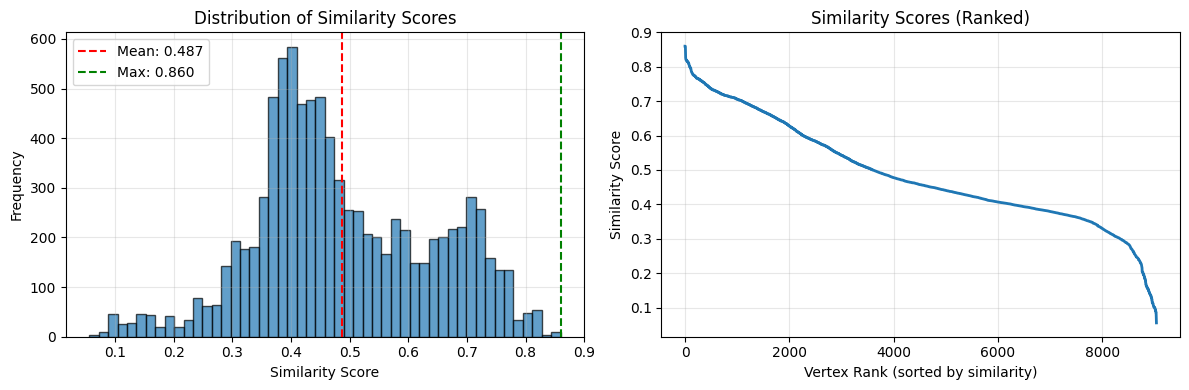

In [12]:
import matplotlib.pyplot as plt 

# Plot similarity distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(raw_similarities, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(raw_similarities.mean(), color='red', linestyle='--', label=f'Mean: {raw_similarities.mean():.3f}')
plt.axvline(raw_similarities.max(), color='green', linestyle='--', label=f'Max: {raw_similarities.max():.3f}')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(sorted(raw_similarities, reverse=True), linewidth=2)
plt.xlabel('Vertex Rank (sorted by similarity)')
plt.ylabel('Similarity Score')
plt.title('Similarity Scores (Ranked)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Interactive Visualization

The main result visualization showing:
- **Left**: Source mesh (gray) with the selected point highlighted in red
- **Right**: Target mesh colored by similarity (warmer colors = more similar)

You can interact with the 3D visualization to rotate and zoom the meshes.

In [14]:
print("🎨 Interactive Visualization:")
print("- Source mesh (left): Gray with red point showing the reference vertex")
print("- Target mesh (right): Colored by similarity (warmer colors = more similar)")
print("- Use mouse to rotate and zoom the 3D view")

# The visualization was already created by run_point_similarity_analysis
# But let's create it again with custom colormap options
visualize_point_similarity(
    source_mesh=source_mesh,
    target_mesh=target_mesh,
    source_point_idx=source_point_idx,
    similarity_colors=similarity_colors,
)

🎨 Interactive Visualization:
- Source mesh (left): Gray with red point showing the reference vertex
- Target mesh (right): Colored by similarity (warmer colors = more similar)
- Use mouse to rotate and zoom the 3D view


Source point (red): vertex 7884
Target mesh colored by similarity to source point
Similarity range: 0.000 to 1.000


## 10. Experiment with Different Points

Try analyzing different points on the source mesh to see how similarity patterns change.

In [15]:
# Experiment with different source points
# You can change these indices and re-run this cell
experiment_points = [100, 500, 1500, 2000]  # Different vertex indices to try

for point_idx in experiment_points:
    if point_idx < len(source_mesh.vert):
        print(f"\n🔬 Experimenting with source vertex {point_idx}...")

        # Quick analysis with fewer views for faster computation
        exp_colors, exp_similarities = point_similarity_colormap(
            device=device,
            pipe=pipe,
            dino_model=dino_model,
            source_mesh=source_mesh,
            target_mesh=target_mesh,
            source_point_idx=point_idx,
            prompt=prompt,
            num_views=10  # Fewer views for quick experiment
        )

        # Show quick stats
        top_match = np.argmax(exp_similarities)
        print(f"  Best match: vertex {top_match} (similarity: {exp_similarities[top_match]:.4f})")

        # Visualize
        visualize_point_similarity(
            source_mesh=source_mesh,
            target_mesh=target_mesh,
            source_point_idx=point_idx,
            similarity_colors=exp_colors,
            colormap='viridis'
        )
    else:
        print(f"Skipping vertex {point_idx} (mesh only has {len(source_mesh.vert)} vertices)")


🔬 Experimenting with source vertex 100...


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:10                                                                                   │
│                                                                                                  │
│    7 │   │   print(f"\n🔬 Experimenting with source vertex {point_idx}...")                      │
│    8 │   │                                                                                       │
│    9 │   │   # Quick analysis with fewer views for faster computation                            │
│ ❱ 10 │   │   exp_colors, exp_similarities = point_similarity_colormap(                           │
│   11 │   │   │   device=device,                                                                  │
│   12 │   │   │   pipe=pipe,                                                                      │
│   13 │   │   │   dino_model=dino_model,                                                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: point_similarity_colormap() missing 1 required positional argument: 'source_point_3d'

## 11. Save Results (Optional)

Save the similarity data for later analysis.

In [ ]:
# Save results to files
output_prefix = f"similarity_results_vertex_{source_point_idx}"

# Save similarity scores
np.save(f"{output_prefix}_similarities.npy", raw_similarities)
np.save(f"{output_prefix}_colors.npy", similarity_colors)

# Save analysis summary
summary = {
    'source_mesh_path': source_mesh_path,
    'target_mesh_path': target_mesh_path,
    'source_point_idx': source_point_idx,
    'prompt': prompt,
    'num_views': num_views,
    'min_similarity': float(raw_similarities.min()),
    'max_similarity': float(raw_similarities.max()),
    'mean_similarity': float(raw_similarities.mean()),
    'std_similarity': float(raw_similarities.std()),
    'top_matches': [int(idx) for idx in most_similar_indices[:5]]
}

import json
with open(f"{output_prefix}_summary.json", 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✅ Results saved:")
print(f"  - Similarities: {output_prefix}_similarities.npy")
print(f"  - Colors: {output_prefix}_colors.npy")
print(f"  - Summary: {output_prefix}_summary.json")

## Summary

This notebook demonstrated how to:

1. ✅ Load and visualize 3D meshes
2. ✅ Extract semantic features using diffusion + DINO models
3. ✅ Compute similarity between a specific source point and all target vertices
4. ✅ Visualize results with interactive 3D plots
5. ✅ Analyze similarity distributions and find best matches
6. ✅ Experiment with different source points
7. ✅ Save results for future analysis

### Next Steps

- Try different mesh pairs
- Experiment with different prompts
- Adjust the number of views for quality vs. speed trade-offs
- Use the saved similarity data for further analysis or applications